In [2]:
import os
import time
import warnings
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.transforms import GaussianBlur

from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from scipy.stats import gaussian_kde
from tqdm import tqdm
from einops import rearrange

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# New class for labeled dataset
class JetDatasetLabeled(Dataset):
    def __init__(self, file_path, jet_key="jet", y_key="Y", pt_key="pT", m_key="m"):
        self.file_path = file_path
        self.jet_key = jet_key
        self.y_key = y_key
        self.pt_key = pt_key
        self.m_key = m_key
        
        with h5py.File(file_path, 'r') as f:
            self.length = f[jet_key].shape[0]
            
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            jet = f[self.jet_key][idx]
            y = f[self.y_key][idx]
            pt = f[self.pt_key][idx]
            m = f[self.m_key][idx]
            
        # Convert shape to [channels, eta, phi]
        jet = torch.tensor(jet, dtype=torch.float32).permute(2, 0, 1)
        y = torch.tensor(y, dtype=torch.long)
        pt = torch.tensor(pt, dtype=torch.float32)
        m = torch.tensor(m, dtype=torch.float32)
        
        return jet, y, pt, m

In [4]:

class ResNetSSL(nn.Module):
    def __init__(self, latent_dim=256, projection_dim=128, resnet_depth=18):
        super().__init__()

        if resnet_depth == 18:
            self.encoder_backbone = models.resnet18(weights=None)
            num_bottleneck_features = 512
        elif resnet_depth == 34:
            self.encoder_backbone = models.resnet34(weights=None)
            num_bottleneck_features = 512
        else:
            raise ValueError("Unsupported ResNet depth")

        original_conv1 = self.encoder_backbone.conv1
        self.encoder_backbone.conv1 = nn.Conv2d(
            8,
            original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=False
        )

        self.encoder_backbone.fc = nn.Identity()

        self.final_layer = nn.Linear(num_bottleneck_features, latent_dim)

        self.projector = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.ReLU(),
            nn.Linear(latent_dim * 2, projection_dim)
        )

    def forward(self, x):
        features_bottleneck = self.encoder_backbone(x)
        features_latent = self.final_layer(features_bottleneck)
        projections = self.projector(features_latent)
        return features_latent, projections

In [5]:
def extract_features(model, dataloader):
    model.eval()
    features_list = []
    y_list = []
    pt_list = []
    m_list = []
    
    with torch.no_grad():
        for jets, y, pt, m in tqdm(dataloader, desc="Extracting features"):
            jets = jets.to(device)
            features, _ = model(jets)
            features_list.append(features.cpu())
            y_list.append(y)
            pt_list.append(pt)
            m_list.append(m)
    
    # Concatenate all batches
    features = torch.cat(features_list, dim=0)
    y = torch.cat(y_list, dim=0)
    pt = torch.cat(pt_list, dim=0)
    m = torch.cat(m_list, dim=0)
    
    return features, y, pt, m


In [6]:
class ShallowRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout_prob=0.2):
        super(ShallowRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [7]:
def load_model(checkpoint_name, model, device):
    checkpoint_path = os.path.join("/kaggle/input/greattt", checkpoint_name)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from {checkpoint_name} (Epoch {checkpoint['epoch']} with Loss {checkpoint['loss']:.4f})")
    return model

# Initialize model
ssl_model = ResNetSSL(latent_dim=256, projection_dim=128, resnet_depth=18).to(device)

# Load the best model
ssl_model = load_model("best_model (20).pt", ssl_model, device)
ssl_model.eval()


labeled_file_path = "/kaggle/input/dataset-specific-labelled-full-only-for-2i/Dataset_Specific_labelled_full_only_for_2i.h5"
batch_size = 256
num_epochs_downstream = 100
latent_dim = 256
print("Loading labeled dataset...")


labeled_dataset = JetDatasetLabeled(labeled_file_path)
labeled_loader = DataLoader(
        labeled_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
)

# Extract features
features, _, pt_values, m_values = extract_features(ssl_model, labeled_loader)

<ipython-input-7-cd5a43893bdf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model from best_model (20).pt (Epoch 22 with Loss 0.0037)
Loading labeled dataset...


Extracting features: 100%|██████████| 40/40 [00:36<00:00,  1.08it/s]


In [12]:
X_train, X_val, pt_train, pt_val, m_train, m_val = train_test_split(
    features, pt_values, m_values, test_size=0.2, random_state=42
)

In [13]:
def plot_regression_results(actuals, predictions, title, mse_score, f1_score):
    """Plots true vs predicted values and includes metrics in the title."""
    plt.figure(figsize=(6, 6))
    plt.scatter(actuals, predictions, alpha=0.5, label="Predictions")
    # Determine plot limits based on actual data range
    min_val = min(np.min(actuals), np.min(predictions))
    max_val = max(np.max(actuals), np.max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2, label="Ideal (y=x)")
    plt.xlabel("True Values (Original Scale)")
    plt.ylabel("Predictions (Original Scale)")
    # Updated title to include metrics, formatted to 4 decimal places
    # Using f-string and \n for a new line
    plot_title = f"{title}\nMSE: {mse_score:.4f} | F1 (binarized): {f1_score:.4f}"
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
def evaluate_regressor(model, loader, target_scaler):

    model.eval()
    predictions_scaled = []
    actuals_scaled = []
    use_amp = device.type == 'cuda'
    
    with torch.no_grad():
        for inputs, targets_scaled_cpu in loader:
            inputs = inputs.to(device)
            # targets_scaled_cpu remain on CPU for inverse transform
            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs_scaled = model(inputs)
            predictions_scaled.extend(outputs_scaled.cpu().numpy())
            actuals_scaled.extend(targets_scaled_cpu.numpy())
    
    predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
    actuals_scaled = np.array(actuals_scaled).reshape(-1, 1)
    
    try:
        # Ensure scaler expects 2D array; reshape if needed.
        if predictions_scaled.ndim == 1:
            predictions_scaled = predictions_scaled.reshape(-1, 1)
        if actuals_scaled.ndim == 1:
            actuals_scaled = actuals_scaled.reshape(-1, 1)
    
        predictions_orig = target_scaler.inverse_transform(predictions_scaled)
        actuals_orig = target_scaler.inverse_transform(actuals_scaled)
    except ValueError as e:
        print(f"Error during inverse transform: {e}.")
        print(f"Shapes - Predictions (scaled): {predictions_scaled.shape}, Actuals (scaled): {actuals_scaled.shape}")
        print(f"Scaler n_features_in_: {getattr(target_scaler, 'n_features_in_', 'N/A')}")
        nan_array = np.full(actuals_scaled.shape[0], np.nan)
        return np.nan, np.nan, np.nan, nan_array, nan_array
    except Exception as e:
        print(f"Unexpected error during inverse transform: {e}")
        nan_array = np.full(actuals_scaled.shape[0], np.nan)
        return np.nan, np.nan, np.nan, nan_array, nan_array
    
    actuals_orig_1d = actuals_orig.flatten()
    predictions_orig_1d = predictions_orig.flatten()
    
    if np.isnan(actuals_orig_1d).any() or np.isnan(predictions_orig_1d).any():
        print("Warning: NaNs detected after inverse transform. Returning NaN metrics.")
        return np.nan, np.nan, np.nan, predictions_orig_1d, actuals_orig_1d
    
    mse_orig = mean_squared_error(actuals_orig_1d, predictions_orig_1d)
    r2_orig = r2_score(actuals_orig_1d, predictions_orig_1d)
    
    # Calculate F1 score (binarized using median of true values on original scale)
    f1_orig = np.nan  # Default to NaN if calculation fails
    if len(actuals_orig_1d) > 1:
        try:
            if np.all(actuals_orig_1d == actuals_orig_1d[0]):
                median_actual_orig = actuals_orig_1d[0]
                print("Warning: All actual values are the same. Binarization for F1 might be trivial.")
            else:
                median_actual_orig = np.median(actuals_orig_1d)
    
            binary_actuals_orig = (actuals_orig_1d > median_actual_orig).astype(int)
            binary_preds_orig = (predictions_orig_1d > median_actual_orig).astype(int)
            f1_orig = f1_score(binary_actuals_orig, binary_preds_orig, zero_division=0)
        except Exception as e:
            print(f"Warning: Could not calculate F1 score. Error: {e}")
    
    return mse_orig, r2_orig, f1_orig, predictions_orig_1d, actuals_orig_1d

In [16]:
def evaluate_regressor(model, loader, target_scaler):

    model.eval()
    predictions_scaled = []
    actuals_scaled = []
    use_amp = device.type == 'cuda'
    
    with torch.no_grad():
        for inputs, targets_scaled_cpu in loader:
            inputs = inputs.to(device)
            # targets_scaled_cpu remain on CPU for inverse transform
            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs_scaled = model(inputs)
            predictions_scaled.extend(outputs_scaled.cpu().numpy())
            actuals_scaled.extend(targets_scaled_cpu.numpy())
    
    predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
    actuals_scaled = np.array(actuals_scaled).reshape(-1, 1)
    
    try:
        # Ensure scaler expects 2D array; reshape if needed.
        if predictions_scaled.ndim == 1:
            predictions_scaled = predictions_scaled.reshape(-1, 1)
        if actuals_scaled.ndim == 1:
            actuals_scaled = actuals_scaled.reshape(-1, 1)
    
        predictions_orig = target_scaler.inverse_transform(predictions_scaled)
        actuals_orig = target_scaler.inverse_transform(actuals_scaled)
    except ValueError as e:
        print(f"Error during inverse transform: {e}.")
        print(f"Shapes - Predictions (scaled): {predictions_scaled.shape}, Actuals (scaled): {actuals_scaled.shape}")
        print(f"Scaler n_features_in_: {getattr(target_scaler, 'n_features_in_', 'N/A')}")
        nan_array = np.full(actuals_scaled.shape[0], np.nan)
        return np.nan, np.nan, np.nan, nan_array, nan_array
    except Exception as e:
        print(f"Unexpected error during inverse transform: {e}")
        nan_array = np.full(actuals_scaled.shape[0], np.nan)
        return np.nan, np.nan, np.nan, nan_array, nan_array
    
    actuals_orig_1d = actuals_orig.flatten()
    predictions_orig_1d = predictions_orig.flatten()
    
    if np.isnan(actuals_orig_1d).any() or np.isnan(predictions_orig_1d).any():
        print("Warning: NaNs detected after inverse transform. Returning NaN metrics.")
        return np.nan, np.nan, np.nan, predictions_orig_1d, actuals_orig_1d
    
    mse_orig = mean_squared_error(actuals_orig_1d, predictions_orig_1d)
    r2_orig = r2_score(actuals_orig_1d, predictions_orig_1d)
    
    # Calculate F1 score (binarized using median of true values on original scale)
    f1_orig = np.nan  # Default to NaN if calculation fails
    if len(actuals_orig_1d) > 1:
        try:
            if np.all(actuals_orig_1d == actuals_orig_1d[0]):
                median_actual_orig = actuals_orig_1d[0]
                print("Warning: All actual values are the same. Binarization for F1 might be trivial.")
            else:
                median_actual_orig = np.median(actuals_orig_1d)
    
            binary_actuals_orig = (actuals_orig_1d > median_actual_orig).astype(int)
            binary_preds_orig = (predictions_orig_1d > median_actual_orig).astype(int)
            f1_orig = f1_score(binary_actuals_orig, binary_preds_orig, zero_division=0)
        except Exception as e:
            print(f"Warning: Could not calculate F1 score. Error: {e}")
    
    return mse_orig, r2_orig, f1_orig, predictions_orig_1d, actuals_orig_1d
def train_regressor_with_validation(model, train_loader, val_loader, target_scaler, criterion, optimizer, epochs, patience=15):
    
    use_amp = device.type == 'cuda'
    scaler = GradScaler(enabled=use_amp)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",      # Based on validation MSE
        factor=0.5,
        patience=5,      
        min_lr=1e-8,
        verbose=False    
    )
    
    best_val_mse = float("inf")
    wait = 0
    best_model_state = None
    
    # Histories
    train_loss_history = []
    train_mse_history = []
    train_f1_history = []
    val_mse_history = []
    val_f1_history = []
    
    print(f"Starting training for {epochs} epochs...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
    
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad(set_to_none=True)
    
            with autocast('cuda', enabled=use_amp):
                outputs = model(inputs)
                # Ensure proper shape adjustment if necessary:
                if outputs.shape != targets.shape:
                    if targets.ndim == 1:
                        targets = targets.unsqueeze(1)
                loss = criterion(outputs, targets)
    
            if not math.isfinite(loss.item()):
                print(f"Warning: Non-finite loss {loss.item()} at epoch {epoch+1}, batch {batch_idx}. Skipping batch.")
                continue
    
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
    
        avg_train_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        epoch_time = time.time() - start_time
        train_loss_history.append(avg_train_loss)
    
        # --- Evaluate on Training Data ---
        train_mse, _, train_f1, _, _ = evaluate_regressor(model, train_loader, target_scaler)
        train_mse_history.append(train_mse)
        train_f1_history.append(train_f1)
    
        # --- Evaluate on Validation Data ---
        val_mse, val_r2, val_f1, _, _ = evaluate_regressor(model, val_loader, target_scaler)
        val_mse_history.append(val_mse)
        val_f1_history.append(val_f1)
    
        # --- Scheduler Step & Logging ---
        if not math.isnan(val_mse):
            scheduler.step(val_mse)
            current_lr = optimizer.param_groups[0]['lr']
            if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Train MSE: {train_mse:.4f} | Train F1: {train_f1:.4f} | Val MSE: {val_mse:.4f} | Val F1: {val_f1:.4f} | Time: {epoch_time:.2f}s | LR: {current_lr:.1e}")
    
        # --- Early Stopping Check ---
        if not math.isnan(val_mse):
            if val_mse < best_val_mse:
                best_val_mse = val_mse
                wait = 0
                best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
            else:
                wait += 1
                if wait >= patience:
                    print(f"\nEarly stopping triggered after {patience} epochs with no improvement on validation MSE.")
                    print(f"Best validation MSE: {best_val_mse:.4f} achieved at epoch {epoch + 1 - patience}")
                    if best_model_state:
                        print("Loading best model state...")
                        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
                    else:
                        print("Warning: Early stopping triggered, but no best model state was saved.")
                    return model, train_loss_history, train_mse_history, train_f1_history, val_mse_history, val_f1_history
        else:
            print(f"Warning: Validation MSE is NaN at epoch {epoch+1}.")
    
    print("\nTraining finished.")
    if best_model_state and wait > 0 and not math.isnan(best_val_mse):
        print(f"Loading best model state from epoch {epoch + 1 - wait} with Val MSE: {best_val_mse:.4f}")
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
    elif not best_model_state:
        print("Warning: Training finished, but no best model state was saved. Returning the final epoch model.")
    else:
        print("Best model performance was achieved in the final epoch.")
    
    return model, train_loss_history, train_mse_history, train_f1_history, val_mse_history, val_f1_history


In [17]:

class DatasetLoader:
    def __init__(self, X_train, y_train, X_val, y_val, batch_size):
        self.batch_size = batch_size
        self.train_loader = self._create_dataloader(X_train, y_train, shuffle=True)
        self.val_loader = self._create_dataloader(X_val, y_val, shuffle=False)

    def _create_dataloader(self, X, y, shuffle):
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle, drop_last=shuffle)

feature_scaler = StandardScaler()
X_trainp = feature_scaler.fit_transform(X_train)
X_valp = feature_scaler.transform(X_val)

target_scaler_pt = StandardScaler()
target_scaler_m = StandardScaler()

pt_trainp = target_scaler_pt.fit_transform(pt_train.reshape(-1, 1))
pt_valp = target_scaler_pt.transform(pt_val.reshape(-1, 1))
m_trainp = target_scaler_m.fit_transform(m_train.reshape(-1, 1))
m_valp = target_scaler_m.transform(m_val.reshape(-1, 1))

batch_size = 256

pt_loader = DatasetLoader(X_trainp, pt_trainp, X_valp, pt_valp, batch_size)
m_loader = DatasetLoader(X_trainp, m_trainp, X_valp, m_valp, batch_size)

In [18]:
input_dim = X_train.shape[1]
pt_regressor = ShallowRegressor(input_dim).to(device)

print("\n--- Training pT Regressor ---")
pt_criterion = nn.MSELoss()
pt_optimizer = optim.AdamW(pt_regressor.parameters(), lr=0.01, weight_decay=5e-4)

start_time = time.time()

# Train pT regressor using the training function
pt_regressor, train_loss_history, train_mse, train_f1, val_mse, val_f1 = train_regressor_with_validation(
    pt_regressor, pt_loader.train_loader, pt_loader.val_loader, target_scaler_pt,
    pt_criterion, pt_optimizer, num_epochs_downstream, patience=15
)


--- Training pT Regressor ---
Starting training for 100 epochs...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 1.103953 | Train MSE: 11478.0303 | Train F1: 0.6675 | Val MSE: 10426.2656 | Val F1: 0.6611 | Time: 0.54s | LR: 1.0e-02
Epoch 10/100 | Train Loss: 0.937408 | Train MSE: 10987.9453 | Train F1: 0.6680 | Val MSE: 10281.6377 | Val F1: 0.6614 | Time: 0.13s | LR: 1.0e-02
Epoch 20/100 | Train Loss: 0.908059 | Train MSE: 10657.5049 | Train F1: 0.6713 | Val MSE: 10184.0068 | Val F1: 0.6657 | Time: 0.11s | LR: 2.5e-03
Epoch 30/100 | Train Loss: 0.895631 | Train MSE: 10363.2158 | Train F1: 0.6723 | Val MSE: 10151.5781 | Val F1: 0.6662 | Time: 0.12s | LR: 1.3e-03
Epoch 40/100 | Train Loss: 0.881482 | Train MSE: 10310.9131 | Train F1: 0.6749 | Val MSE: 10086.5537 | Val F1: 0.6648 | Time: 0.11s | LR: 1.3e-03
Epoch 50/100 | Train Loss: 0.878282 | Train MSE: 10185.6289 | Train F1: 0.6755 | Val MSE: 10093.1768 | Val F1: 0.6651 | Time: 0.12s | LR: 6.3e-04

Early stopping triggered after 15 epochs with no improvement on validation MSE.
Best validation MSE: 10068.3965 achieved at 


--- Final Evaluation on Validation Set ---
pT Regressor:
Validation pT MSE (Original Scale): 10068.3965
Validation pT R2 Score (Original Scale): 0.0662
Validation pT F1 Score (binarized, orig): 0.6630


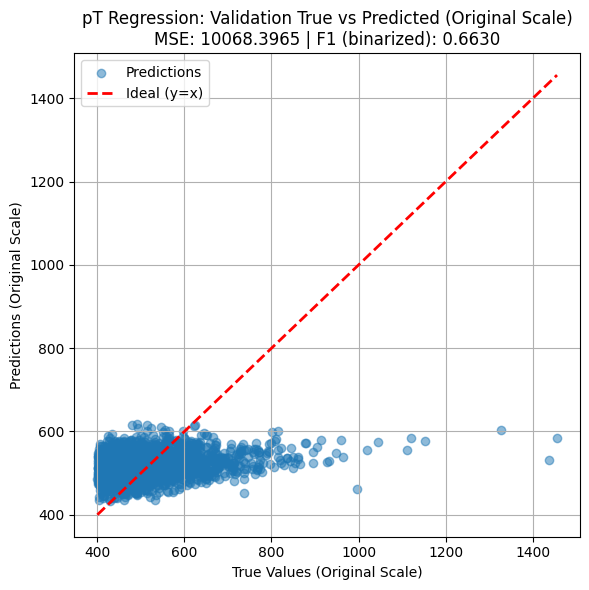

In [19]:
# --- Final Evaluation on Validation Set for pT regressor ---
print("\n--- Final Evaluation on Validation Set ---")
print("pT Regressor:")
pt_val_mse_orig, pt_val_r2_orig, pt_val_f1_orig, pt_val_preds_orig, pt_val_actuals_orig = evaluate_regressor(
    pt_regressor, pt_loader.val_loader, target_scaler_pt  # 🔹 Corrected argument order
)
print(f"Validation pT MSE (Original Scale): {pt_val_mse_orig:.4f}")
print(f"Validation pT R2 Score (Original Scale): {pt_val_r2_orig:.4f}")
print(f"Validation pT F1 Score (binarized, orig): {pt_val_f1_orig:.4f}")

plot_regression_results(pt_val_actuals_orig, pt_val_preds_orig, "pT Regression: Validation True vs Predicted (Original Scale)", mse_score=pt_val_mse_orig, f1_score=pt_val_f1_orig)

In [21]:
torch.save(pt_regressor.state_dict(),"/kaggle/working/Downstream_pt_regressor_ResNetSSL.pth" )
print("Model weights")

Model weights


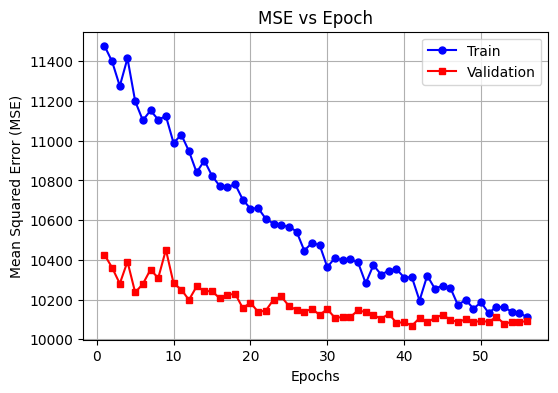

In [22]:
epochs = range(1, len(train_mse) + 1)
plt.figure(figsize=(6, 4)) 
plt.plot(epochs, train_mse, 'bo-', label='Train', markersize=5, linewidth=1.5)  # Blue with circles
plt.plot(epochs, val_mse, 'rs-', label='Validation', markersize=5, linewidth=1.5)  # Red with squares
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


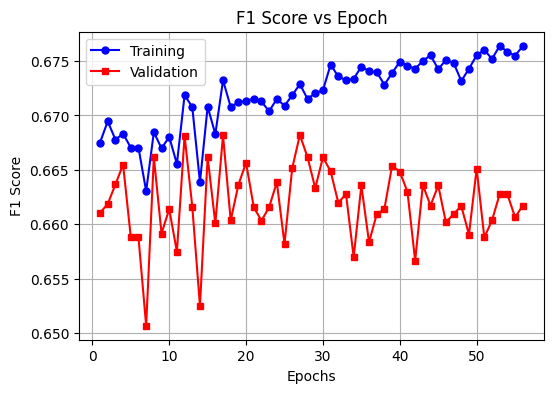

In [23]:
plt.figure(figsize=(6, 4)) 
plt.plot(epochs, train_f1, 'bo-', label='Training', markersize=5, linewidth=1.5)  # Blue with circles
plt.plot(epochs, val_f1, 'rs-', label='Validation', markersize=5, linewidth=1.5)  # Red with squares
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
m_regressor = ShallowRegressor(input_dim).to(device)

print("\n--- Training m Regressor ---")
m_criterion = nn.MSELoss()
m_optimizer = optim.AdamW(m_regressor.parameters(), lr=0.01, weight_decay=5e-4)

start_time = time.time()

# Train m regressor using the training function
m_regressor, train_loss_history, train_mse, train_f1, val_mse, val_f1 = train_regressor_with_validation(
    m_regressor, m_loader.train_loader, m_loader.val_loader, target_scaler_m,
    m_criterion, m_optimizer, num_epochs_downstream, patience=15
)



--- Training m Regressor ---
Starting training for 100 epochs...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 0.528493 | Train MSE: 968.0946 | Train F1: 0.8575 | Val MSE: 987.8519 | Val F1: 0.8709 | Time: 0.12s | LR: 1.0e-02
Epoch 10/100 | Train Loss: 0.362897 | Train MSE: 884.2029 | Train F1: 0.8651 | Val MSE: 927.5505 | Val F1: 0.8775 | Time: 0.11s | LR: 1.0e-02
Epoch 20/100 | Train Loss: 0.349945 | Train MSE: 852.9015 | Train F1: 0.8664 | Val MSE: 919.6484 | Val F1: 0.8722 | Time: 0.11s | LR: 1.0e-02
Epoch 30/100 | Train Loss: 0.333550 | Train MSE: 828.7092 | Train F1: 0.8718 | Val MSE: 908.6830 | Val F1: 0.8752 | Time: 0.11s | LR: 5.0e-03
Epoch 40/100 | Train Loss: 0.332031 | Train MSE: 799.3557 | Train F1: 0.8728 | Val MSE: 887.6495 | Val F1: 0.8775 | Time: 0.11s | LR: 2.5e-03
Epoch 50/100 | Train Loss: 0.323732 | Train MSE: 788.5886 | Train F1: 0.8731 | Val MSE: 887.8466 | Val F1: 0.8770 | Time: 0.11s | LR: 2.5e-03
Epoch 60/100 | Train Loss: 0.315674 | Train MSE: 763.4888 | Train F1: 0.8745 | Val MSE: 883.7704 | Val F1: 0.8773 | Time: 0.11s | LR: 6.3e-04
Epoch 7


--- Final Evaluation on Validation Set ---
m Regressor:
Validation m MSE (Original Scale): 880.6902
Validation m R2 Score (Original Scale): 0.6743
Validation m F1 Score (binarized, orig): 0.8779


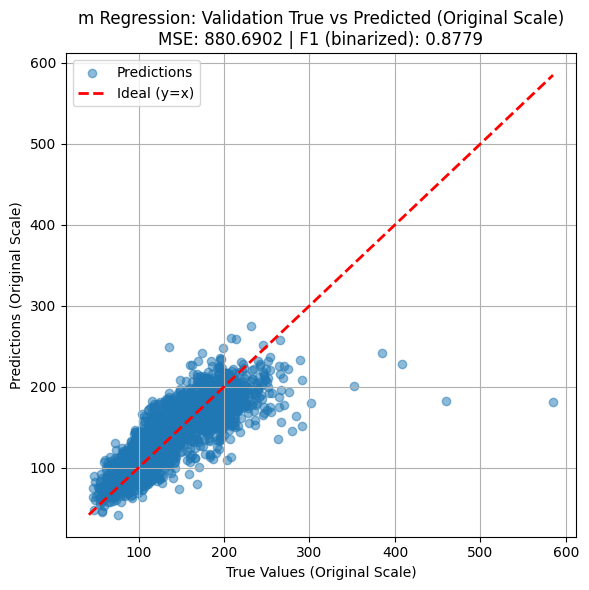

In [25]:
# --- Final Evaluation on Validation Set for m regressor ---
print("\n--- Final Evaluation on Validation Set ---")
print("m Regressor:")
m_val_mse_orig, m_val_r2_orig, m_val_f1_orig, m_val_preds_orig, m_val_actuals_orig = evaluate_regressor(
    m_regressor, m_loader.val_loader, target_scaler_m  # 🔹 Corrected argument order
)
print(f"Validation m MSE (Original Scale): {m_val_mse_orig:.4f}")
print(f"Validation m R2 Score (Original Scale): {m_val_r2_orig:.4f}")
print(f"Validation m F1 Score (binarized, orig): {m_val_f1_orig:.4f}")

plot_regression_results(m_val_actuals_orig, m_val_preds_orig, "m Regression: Validation True vs Predicted (Original Scale)", mse_score=m_val_mse_orig, f1_score=m_val_f1_orig)

In [26]:
torch.save(m_regressor.state_dict(),"/kaggle/working/Downstream_m_regressor_ResNetSSL.pth" )
print("Model weights")

Model weights


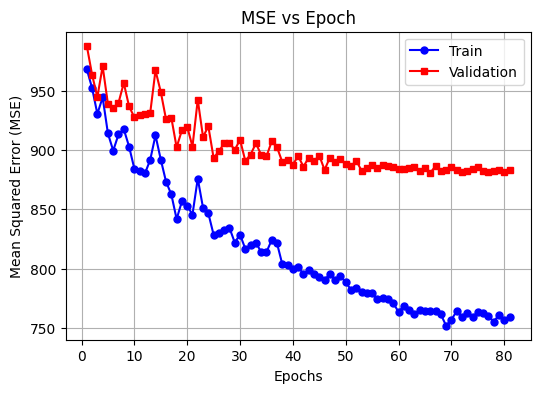

In [27]:
epochs = range(1, len(train_mse) + 1)
plt.figure(figsize=(6, 4)) 
plt.plot(epochs, train_mse, 'bo-', label='Train', markersize=5, linewidth=1.5)  # Blue with circles
plt.plot(epochs, val_mse, 'rs-', label='Validation', markersize=5, linewidth=1.5)  # Red with squares
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

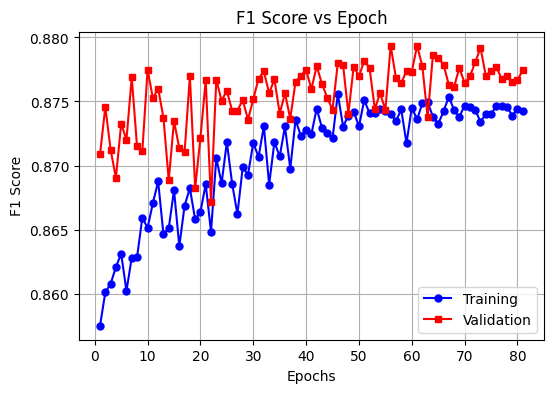

In [28]:
plt.figure(figsize=(6, 4)) 
plt.plot(epochs, train_f1, 'bo-', label='Training', markersize=5, linewidth=1.5)  # Blue with circles
plt.plot(epochs, val_f1, 'rs-', label='Validation', markersize=5, linewidth=1.5)  # Red with squares
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epoch')
plt.legend()
plt.grid(True)
plt.show()
